# O Efeito Lente das Nuvens na Irradiância Solar: Modelagem e Análise Computacional

## Descrição do Projeto

Este projeto investiga o fenômeno conhecido como **efeito lente das nuvens**, no qual as nuvens, apesar de frequentemente bloquearem a radiação solar, em determinadas condições atmosféricas podem intensificá-la devido à reflexão e refração da luz. A proposta é realizar uma análise estatística e computacional detalhada da irradiância solar em relação às variáveis meteorológicas, com foco especial na presença de nuvens e eventos de precipitação.

A partir de dados meteorológicos horários, exploramos:

- A distribuição e variabilidade da irradiância solar ao longo do tempo;
- O impacto da precipitação, umidade e vento sobre os níveis de radiação solar;
- A existência de diferenças estatisticamente significativas sob diferentes condições atmosféricas;
- Identificar padrões diurnos, sazonais e horários de máxima incidência;

Os dados foram cuidadosamente pré-processados com tratamento de ausentes, transformação de tipos e discretização de radiação. A análise descritiva revelou padrões típicos do comportamento solar, enquanto os testes de hipóteses confirmaram influências significativas da umidade e do vento. A modelagem preditiva indicou bom desempenho com o uso de regressão por florestas aleatórias.

O objetivo final é compreender melhor como o comportamento das nuvens influencia a disponibilidade de energia solar, o que tem aplicações importantes em **geração de energia fotovoltaica**, **climatologia** e **meteorologia computacional**.


## Pré - Processamento dos Dados


Nesta seção, realizamos o pré-processamento dos dados meteorológicos. As etapas incluem:
1. Conversão de tipos de dados (datas, numéricos, categóricos);
2. Tratamento de dados ausentes;
3. Normalização de variáveis contínuas;
4. Discretização de variáveis numéricas;
5. Limpeza geral dos dados.


In [6]:
# Instalando os pacotes necessários
%pip install pandas matplotlib seaborn

# Importando os pacotes necessários
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Note: you may need to restart the kernel to use updated packages.


In [13]:
df_dados = pd.read_csv('dados.csv', encoding='latin1', sep = ';', decimal =',')

In [14]:
# Conversão de datas e hora
df_dados['Data'] = pd.to_datetime(df_dados['Data'], format='%d/%m/%y', errors='coerce')
df_dados['Hora UTC'] = df_dados['Hora UTC'].str.extract(r'(\d{2})')[0].astype(float)

# Conversão de vírgulas para pontos e conversão numérica
for col in df_dados.columns:
    if df_dados[col].dtype == object:
        df_dados[col] = df_dados[col].str.replace(',', '.')
        df_dados[col] = pd.to_numeric(df_dados[col], errors='ignore')

In [15]:
df_dados.head(20)

,Data,Hora UTC,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (Kj/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C),UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)"
0,2024-01-01,0.0,0.0,1003.9,1003.9,1002.7,NaN,25.6,24.1,26.2,25.6,24.1,23.9,92.0,87.0,92.0,29.0,4.8,1.8
1,2024-01-01,1.0,0.0,1003.9,1004.1,1003.9,NaN,25.7,24.2,25.8,25.6,24.3,24.1,92.0,91.0,91.0,61.0,3.7,2.2
2,2024-01-01,2.0,0.0,1004.1,1004.1,1003.9,NaN,25.1,23.9,25.7,25.1,24.2,23.9,93.0,91.0,93.0,36.0,3.7,1.4
3,2024-01-01,3.0,0.0,1003.6,1004.2,1003.6,NaN,24.4,23.8,25.2,24.3,24.1,23.6,97.0,93.0,97.0,37.0,2.1,1.1
4,2024-01-01,4.0,0.0,1003.3,1003.7,1003.3,NaN,24.2,23.7,24.6,24.2,24.0,23.7,97.0,96.0,97.0,112.0,1.4,0.1
5,2024-01-01,5.0,0.0,1003.3,1003.3,1003.1,NaN,24.3,23.9,24.4,24.0,24.1,23.7,99.0,97.0,98.0,330.0,1.6,0.6
6,2024-01-01,6.0,0.0,1003.1,1003.3,1003.0,NaN,24.9,24.2,24.9,24.3,24.2,24.0,98.0,96.0,96.0,27.0,1.5,1.0
7,2024-01-01,7.0,0.0,1003.1,1003.2,1003.0,NaN,24.3,23.5,25.0,24.3,24.2,23.5,96.0,95.0,95.0,38.0,1.8,1.1
8,2024-01-01,8.0,0.0,1003.4,1003.4,1003.0,NaN,23.9,23.5,24.3,23.9,23.8,23.5,98.0,96.0,98.0,143.0,1.7,0.4
9,2024-01-01,9.0,0.0,1003.7,1003.7,1003.3,225.9,26.0,24.1,26.1,23.8,24.7,23.5,99.0,89.0,89.0,2.0,1.0,0.6


In [16]:
# Visualização de valores ausentes
df_dados.isnull().sum()

# # Preenchimento com média
# df_dados['RADIACAO GLOBAL (Kj/m²)'] = df_dados['RADIACAO GLOBAL (Kj/m²)'].fillna(df_dados['RADIACAO GLOBAL (Kj/m²)'].mean())

# Exclusão de linhas com ausentes críticos
df_dados.dropna(subset=['UMIDADE RELATIVA DO AR, HORARIA (%)'], inplace=True)


In [17]:
# Remover duplicatas
df_dados.drop_duplicates(inplace=True)

# Substitui valores inválidos
df_dados.replace(['////', 'ND', 'null', 'NaN'], pd.NA, inplace=True)

In [20]:
#instalação do pacote necessário para normalização
%pip install scikit-learn

from sklearn.preprocessing import MinMaxScaler

# Seleção de colunas numéricas para normalizar
colunas_norm = ['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)', 'UMIDADE RELATIVA DO AR, HORARIA (%)']
scaler = MinMaxScaler()
df_dados[colunas_norm] = scaler.fit_transform(df_dados[colunas_norm])


Note: you may need to restart the kernel to use updated packages.


## Análise Estatística e Teste de Hipóteses
Análise estatística descritiva e um teste de hipóteses sobre o efeito das nuvens na irradiância solar de acordo com a base de dados.

In [ ]:
from scipy.stats import ttest_ind

df_dados = pd.read_csv('dados.csv', encoding='latin1', sep = ';', decimal =',')
# Pré-processamento dos dados
for col in df_dados.columns:
    if df_dados[col].dtype == object:
        df_dados[col] = df_dados[col].str.replace(',', '.')
        try:
            df_dados[col] = df_dados[col].astype(float)
        except:
            pass

# Estatísticas descritivas
df_dados['RADIACAO GLOBAL (Kj/m²)'] = pd.to_numeric(df_dados['RADIACAO GLOBAL (Kj/m²)'], errors='coerce')
desc_stats = df_dados.describe()
display(desc_stats)

,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (Kj/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C),UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)"
count,8781.000000,8781.000000,8781.000000,8781.000000,4832.000000,8781.000000,8744.000000,8781.000000,8781.000000,8738.000000,8738.000000,8740.000000,8740.000000,8744.000000,8781.000000,8781.000000,8781.000000
mean,0.204259,1005.261269,1005.496265,1005.029142,1429.564797,25.954049,22.807880,26.517777,25.436203,23.250870,22.349771,86.652288,81.047483,83.988106,131.158980,5.334609,2.483032
std,1.029694,2.524638,2.512754,2.525838,1117.955896,2.808570,1.768663,2.999847,2.632651,1.717833,1.868420,12.160296,14.604968,13.410033,93.178518,2.773336,1.621587
min,0.000000,998.300000,998.800000,998.200000,0.000000,18.400000,14.400000,18.600000,18.100000,15.400000,13.200000,45.000000,38.000000,42.000000,1.000000,0.600000,0.100000
25%,0.000000,1003.300000,1003.600000,1003.100000,335.350000,24.000000,21.500000,24.300000,23.600000,22.000000,21.100000,78.000000,69.000000,74.000000,65.000000,2.800000,1.000000
50%,0.000000,1005.000000,1005.200000,1004.800000,1346.550000,25.600000,22.900000,26.100000,25.200000,23.300000,22.500000,89.000000,83.000000,86.000000,103.000000,5.100000,2.200000
75%,0.000000,1007.100000,1007.300000,1006.800000,2350.600000,27.800000,24.200000,28.600000,27.200000,24.600000,23.900000,98.000000,94.000000,96.000000,175.000000,7.700000,3.800000
max,33.800000,1012.500000,1012.700000,1012.400000,4048.900000,35.200000,27.500000,35.900000,34.200000,28.100000,26.500000,100.000000,100.000000,100.000000,360.000000,16.000000,7.800000


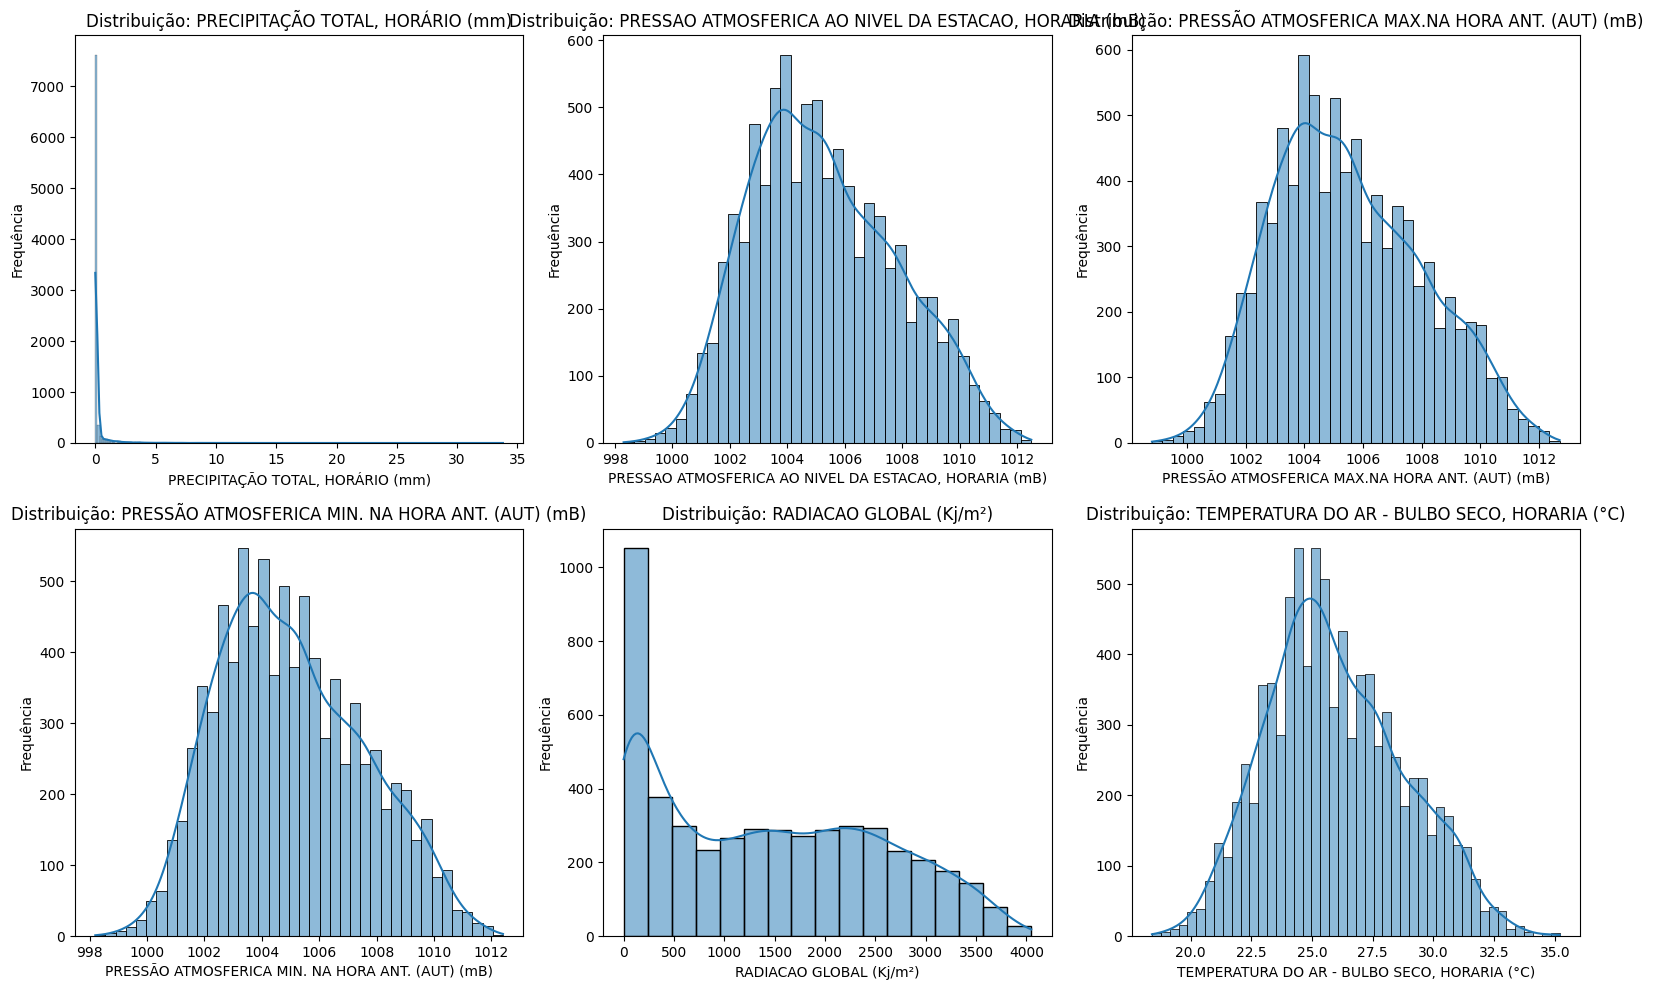

In [22]:
# Histograma de variáveis principais
numeric_cols = df_dados.select_dtypes(include='number').columns
plt.figure(figsize=(16, 10))
for i, col in enumerate(numeric_cols[:6], 1):
    plt.subplot(2, 3, i)
    sns.histplot(df_dados[col].dropna(), kde=True)
    plt.title(f'Distribuição: {col}')
    plt.xlabel(col)
    plt.ylabel('Frequência')
plt.tight_layout()
plt.show()

##### Teste de hipóteses: efeito da precipitação na irradiância

Estatística t: 26.85, p-valor: 2.55e-126


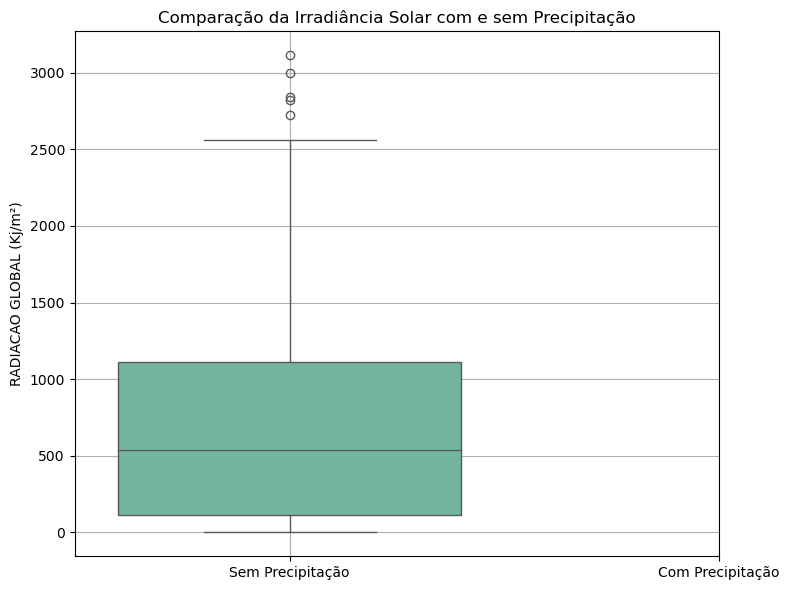

In [ ]:
# Teste de hipóteses: efeito da precipitação na irradiância
df_dados['Precipitacao'] = df_dados['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'] > 0
grupo_com_chuva = df_dados[df_dados['Precipitacao']]['RADIACAO GLOBAL (Kj/m²)'].dropna()
grupo_sem_chuva = df_dados[~df_dados['Precipitacao']]['RADIACAO GLOBAL (Kj/m²)'].dropna()

t_stat, p_value = ttest_ind(grupo_sem_chuva, grupo_com_chuva, equal_var=False)
print(f'Estatística t: {t_stat:.2f}, p-valor: {p_value:.2e}')

# Boxplot comparativo
plt.figure(figsize=(8, 6))
sns.boxplot(data=[grupo_sem_chuva, grupo_com_chuva], palette="Set2")
plt.xticks([0, 1], ['Sem Precipitação', 'Com Precipitação'])
plt.ylabel('RADIACAO GLOBAL (Kj/m²)')
plt.title('Comparação da Irradiância Solar com e sem Precipitação')
plt.grid(True)
plt.tight_layout()
plt.show()

## Correlação entre Variáveis Meteorológicas

Esta etapa analisa a correlação entre a radiação solar e outras variáveis climáticas como temperatura, umidade e vento. Utilizamos uma matriz de correlação e um heatmap para visualizar as relações lineares entre as variáveis.


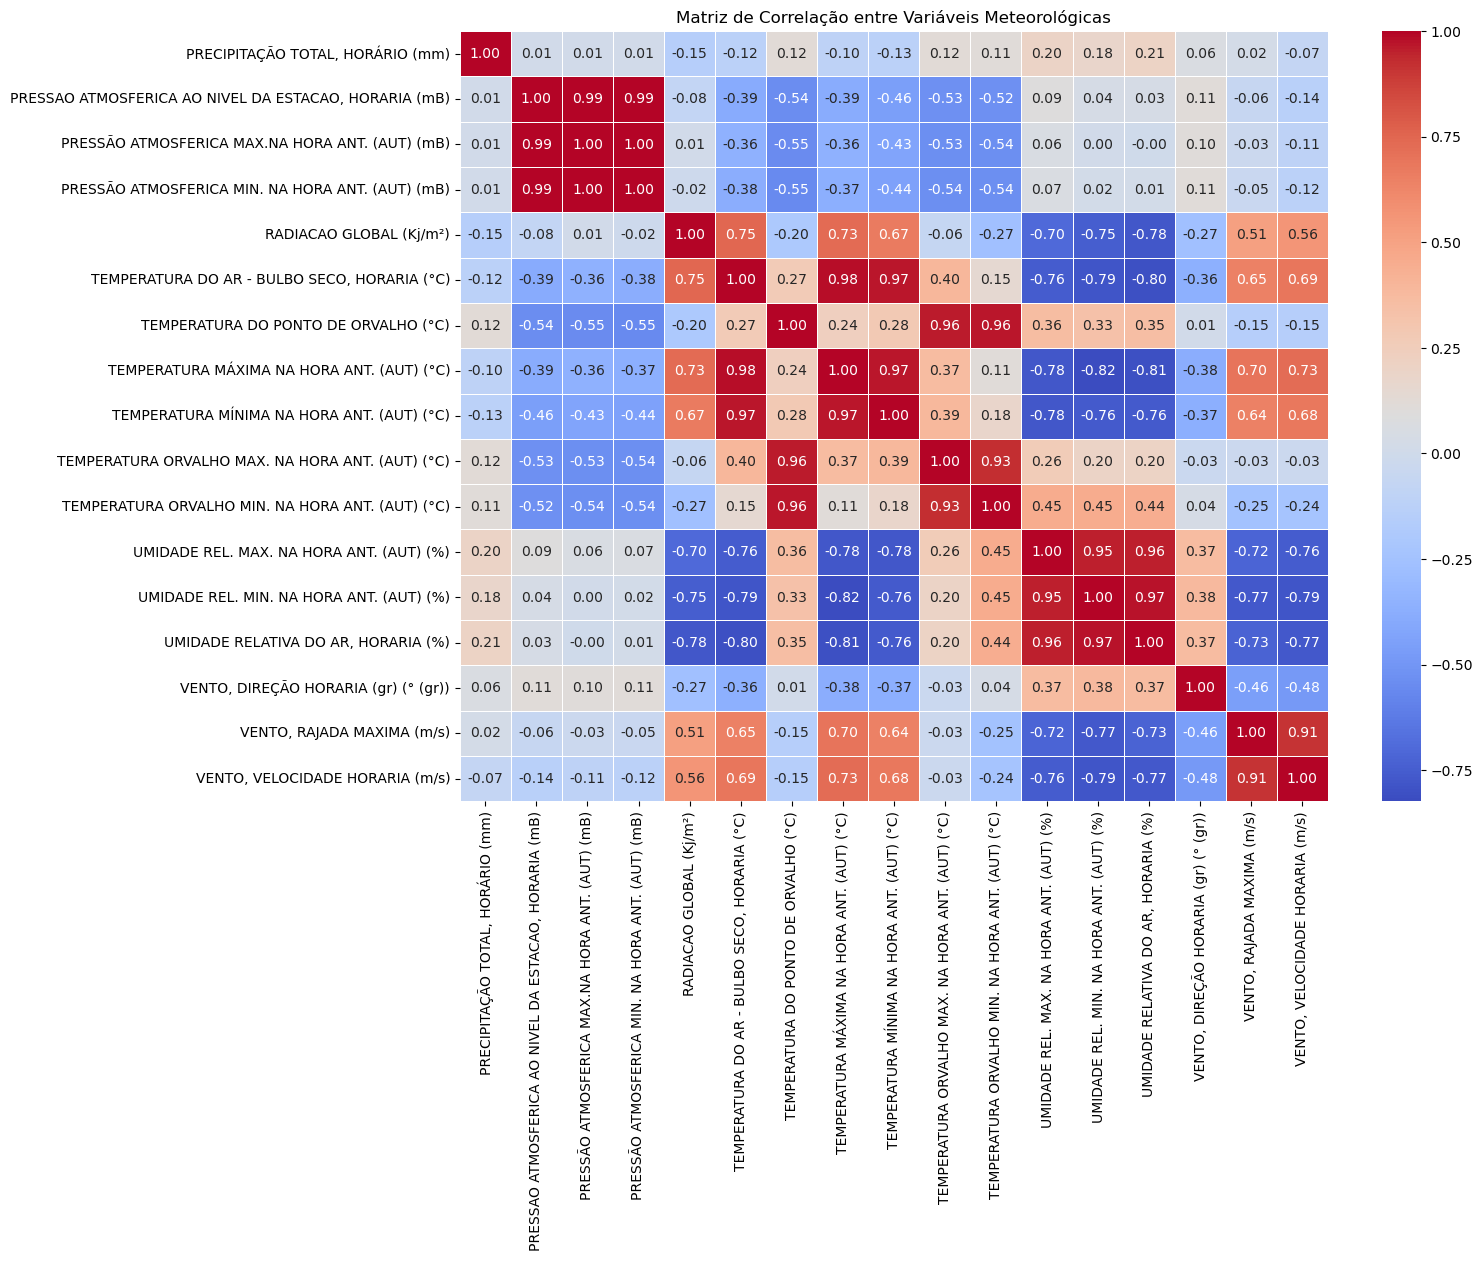

In [ ]:
# Selecionar apenas colunas numéricas
numericas = df_dados.select_dtypes(include='number')

# Calcular matriz de correlação
correlacao = numericas.corr()

# Exibir heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlacao, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriz de Correlação entre Variáveis Meteorológicas')
plt.show()


## Testes de Hipóteses 

Além da influência da precipitação, investigamos aqui se há diferença significativa na irradiância solar em função da:

- **Umidade relativa do ar** (alta vs. baixa);
- **Velocidade do vento** (forte vs. fraco).

Utilizamos testes t de Student para amostras independentes com variâncias diferentes.


In [ ]:
from scipy.stats import ttest_ind

# Buscar Valores numéricos
df_dia['UMIDADE RELATIVA DO AR, HORARIA (%)'] = pd.to_numeric(df_dia['UMIDADE RELATIVA DO AR, HORARIA (%)'], errors='coerce')
df_dia['VENTO, VELOCIDADE HORARIA (m/s)'] = pd.to_numeric(df_dia['VENTO, VELOCIDADE HORARIA (m/s)'], errors='coerce')

# Umidade
umidade_alta = df_dia[df_dia['UMIDADE RELATIVA DO AR, HORARIA (%)'] >= 80]['RADIACAO GLOBAL (Kj/m²)'].dropna()
umidade_baixa = df_dia[df_dia['UMIDADE RELATIVA DO AR, HORARIA (%)'] < 80]['RADIACAO GLOBAL (Kj/m²)'].dropna()
t_umid, p_umid = ttest_ind(umidade_baixa, umidade_alta, equal_var=False)

# Vento
vento_forte = df_dia[df_dia['VENTO, VELOCIDADE HORARIA (m/s)'] >= 3]['RADIACAO GLOBAL (Kj/m²)'].dropna()
vento_fraco = df_dia[df_dia['VENTO, VELOCIDADE HORARIA (m/s)'] < 3]['RADIACAO GLOBAL (Kj/m²)'].dropna()
t_vento, p_vento = ttest_ind(vento_fraco, vento_forte, equal_var=False)

print(f'Teste Umidade: t = {t_umid:.2f}, p = {p_umid:.2e}')
print('Diferença altamente significativa: a irradiância solar é maior em condições de baixa umidade')
print(f'Teste Vento: t = {t_vento:.2f}, p = {p_vento:.2e}')
print('Diferença altamente significativa: a irradiância tende a ser menor com vento forte, possivelmente pela associação com nuvens carregadas e frentes frias.')


Teste Umidade: t = 73.29, p = 0.00e+00
Diferença altamente significativa: a irradiância solar é maior em condições de baixa umidade
Teste Vento: t = -52.14, p = 0.00e+00
Diferença altamente significativa: a irradiância tende a ser menor com vento forte, possivelmente pela associação com nuvens carregadas e frentes frias.


## Coleta de dados da radiação


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('dados.csv', encoding='latin1', sep = ';', decimal =',')
data.head(10)

,Data,Hora UTC,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (Kj/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C),UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)"
0,01/01/24,0000 UTC,0.0,1003.9,1003.9,1002.7,NaN,25.6,24.1,26.2,25.6,24.1,23.9,92.0,87.0,92.0,29.0,4.8,1.8
1,01/01/24,0100 UTC,0.0,1003.9,1004.1,1003.9,NaN,25.7,24.2,25.8,25.6,24.3,24.1,92.0,91.0,91.0,61.0,3.7,2.2
2,01/01/24,0200 UTC,0.0,1004.1,1004.1,1003.9,NaN,25.1,23.9,25.7,25.1,24.2,23.9,93.0,91.0,93.0,36.0,3.7,1.4
3,01/01/24,0300 UTC,0.0,1003.6,1004.2,1003.6,NaN,24.4,23.8,25.2,24.3,24.1,23.6,97.0,93.0,97.0,37.0,2.1,1.1
4,01/01/24,0400 UTC,0.0,1003.3,1003.7,1003.3,NaN,24.2,23.7,24.6,24.2,24.0,23.7,97.0,96.0,97.0,112.0,1.4,0.1
5,01/01/24,0500 UTC,0.0,1003.3,1003.3,1003.1,NaN,24.3,23.9,24.4,24.0,24.1,23.7,99.0,97.0,98.0,330.0,1.6,0.6
6,01/01/24,0600 UTC,0.0,1003.1,1003.3,1003.0,NaN,24.9,24.2,24.9,24.3,24.2,24.0,98.0,96.0,96.0,27.0,1.5,1.0
7,01/01/24,0700 UTC,0.0,1003.1,1003.2,1003.0,NaN,24.3,23.5,25.0,24.3,24.2,23.5,96.0,95.0,95.0,38.0,1.8,1.1
8,01/01/24,0800 UTC,0.0,1003.4,1003.4,1003.0,NaN,23.9,23.5,24.3,23.9,23.8,23.5,98.0,96.0,98.0,143.0,1.7,0.4
9,01/01/24,0900 UTC,0.0,1003.7,1003.7,1003.3,225.9,26.0,24.1,26.1,23.8,24.7,23.5,99.0,89.0,89.0,2.0,1.0,0.6


In [ ]:
df_radiacao = data[['Data','Hora UTC', 'RADIACAO GLOBAL (Kj/m²)']]

In [ ]:
df_radiacao.head(10)

,Data,Hora UTC,RADIACAO GLOBAL (Kj/m²)
0,01/01/24,0000 UTC,NaN
1,01/01/24,0100 UTC,NaN
2,01/01/24,0200 UTC,NaN
3,01/01/24,0300 UTC,NaN
4,01/01/24,0400 UTC,NaN
5,01/01/24,0500 UTC,NaN
6,01/01/24,0600 UTC,NaN
7,01/01/24,0700 UTC,NaN
8,01/01/24,0800 UTC,NaN
9,01/01/24,0900 UTC,225.9


In [ ]:
df_radiacao = df_radiacao.dropna()

In [ ]:
print(df_radiacao)

          Data  Hora UTC  RADIACAO GLOBAL (Kj/m²)
9     01/01/24  0900 UTC                    225.9
10    01/01/24  1000 UTC                    949.0
11    01/01/24  1100 UTC                   1743.4
12    01/01/24  1200 UTC                   2661.2
13    01/01/24  1300 UTC                   2034.2
...        ...       ...                      ...
8777  31/12/24  1700 UTC                   3142.4
8778  31/12/24  1800 UTC                   2480.1
8779  31/12/24  1900 UTC                   1398.7
8780  31/12/24  2000 UTC                    257.7
8781  31/12/24  2100 UTC                     65.7

[4832 rows x 3 columns]


In [ ]:
df_radiacao.shape

(4832, 3)

In [ ]:
df_radiacao.to_csv('radiacao.csv',sep=';')

In [ ]:
df_radiacao['Hora UTC'] = pd.to_datetime(df_radiacao['Data'] + df_radiacao['Hora UTC'], format='%d/%m/%y%H%M UTC',utc=True)

# Converta para o fuso horário local
df_radiacao['Hora Local'] = df_radiacao['Hora UTC'].dt.tz_convert('America/Sao_Paulo')

df_radiacao.head()

,Data,Hora UTC,RADIACAO GLOBAL (Kj/m²),Hora Local
9,01/01/24,2024-01-01 09:00:00+00:00,225.9,2024-01-01 06:00:00-03:00
10,01/01/24,2024-01-01 10:00:00+00:00,949.0,2024-01-01 07:00:00-03:00
11,01/01/24,2024-01-01 11:00:00+00:00,1743.4,2024-01-01 08:00:00-03:00
12,01/01/24,2024-01-01 12:00:00+00:00,2661.2,2024-01-01 09:00:00-03:00
13,01/01/24,2024-01-01 13:00:00+00:00,2034.2,2024-01-01 10:00:00-03:00


In [ ]:
df_radiacao = df_radiacao[df_radiacao['Hora Local'].dt.hour.between(6, 18)]

df_radiacao.head(20)

,Data,Hora UTC,RADIACAO GLOBAL (Kj/m²),Hora Local
9,01/01/24,2024-01-01 09:00:00+00:00,225.9,2024-01-01 06:00:00-03:00
10,01/01/24,2024-01-01 10:00:00+00:00,949.0,2024-01-01 07:00:00-03:00
11,01/01/24,2024-01-01 11:00:00+00:00,1743.4,2024-01-01 08:00:00-03:00
12,01/01/24,2024-01-01 12:00:00+00:00,2661.2,2024-01-01 09:00:00-03:00
13,01/01/24,2024-01-01 13:00:00+00:00,2034.2,2024-01-01 10:00:00-03:00
14,01/01/24,2024-01-01 14:00:00+00:00,3482.3,2024-01-01 11:00:00-03:00
15,01/01/24,2024-01-01 15:00:00+00:00,3969.7,2024-01-01 12:00:00-03:00
16,01/01/24,2024-01-01 16:00:00+00:00,3476.1,2024-01-01 13:00:00-03:00
17,01/01/24,2024-01-01 17:00:00+00:00,3040.6,2024-01-01 14:00:00-03:00
18,01/01/24,2024-01-01 18:00:00+00:00,2438.4,2024-01-01 15:00:00-03:00


In [ ]:
df_radiacao.shape

(4721, 4)

In [ ]:
# Formatar Hora UTC sem timezone
df_radiacao['Hora UTC'] = df_radiacao['Hora UTC'].dt.strftime('%H:%M')

# Se quiser também para Hora Local:
df_radiacao['Hora Local'] = df_radiacao['Hora Local'].dt.strftime('%H:%M')


In [ ]:
df_radiacao

,Data,Hora UTC,RADIACAO GLOBAL (Kj/m²),Hora Local
9,01/01/24,09:00,225.9,06:00
10,01/01/24,10:00,949.0,07:00
11,01/01/24,11:00,1743.4,08:00
12,01/01/24,12:00,2661.2,09:00
13,01/01/24,13:00,2034.2,10:00
...,...,...,...,...
8777,31/12/24,17:00,3142.4,14:00
8778,31/12/24,18:00,2480.1,15:00
8779,31/12/24,19:00,1398.7,16:00
8780,31/12/24,20:00,257.7,17:00


In [ ]:
dias = df_radiacao['Data'].to_list()

In [ ]:
len(set(dias))

366

## Análise Temporal da Irradiância Solar 

### Analise do padrão médio de irradiância solar ao longo do dia, além de usar o dataframe para explorar padrões horários, diários e mensais da irradiância solar. Isso permite observar o comportamento puro da radiação sem influência de outras variáveis.

As análises incluem:

- Boxplots por hora do dia;
- Curvas médias horárias, diárias e mensais;
- Geração de séries temporais.

Essas visualizações ajudam a entender melhor a dinâmica da irradiância solar ao longo do tempo.

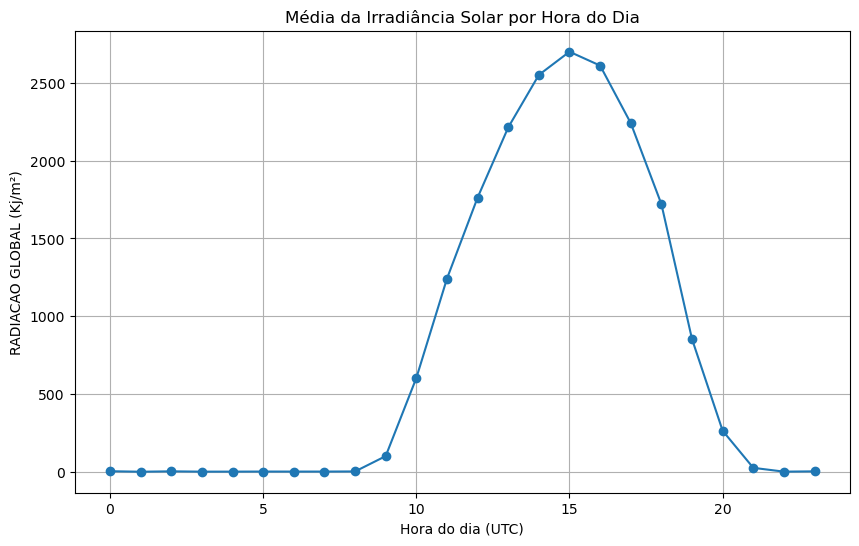

In [ ]:

import pandas as pd
import matplotlib.pyplot as pl

# Carregar dados temporais de radiação
df_radiacao = pd.read_csv('radiacao.csv', sep=';', encoding='utf-8')
df_radiacao['Data'] = pd.to_datetime(df_radiacao['Data'], format='%d/%m/%y', errors='coerce')
df_radiacao['Hora'] = df_radiacao['Hora UTC'].str.extract(r'(\d{2})')[0].astype(int)
df_radiacao['RADIACAO GLOBAL (Kj/m²)'] = pd.to_numeric(df_radiacao['RADIACAO GLOBAL (Kj/m²)'], errors='coerce')

# Calcular a média de irradiância por hora do dia
media_horaria = df_radiacao.groupby('Hora')['RADIACAO GLOBAL (Kj/m²)'].mean()

# Plot da média horária
plt.figure(figsize=(10, 6))
media_horaria.plot(marker='o')
plt.title('Média da Irradiância Solar por Hora do Dia')
plt.xlabel('Hora do dia (UTC)')
plt.ylabel('RADIACAO GLOBAL (Kj/m²)')
plt.grid(True)
plt.show()


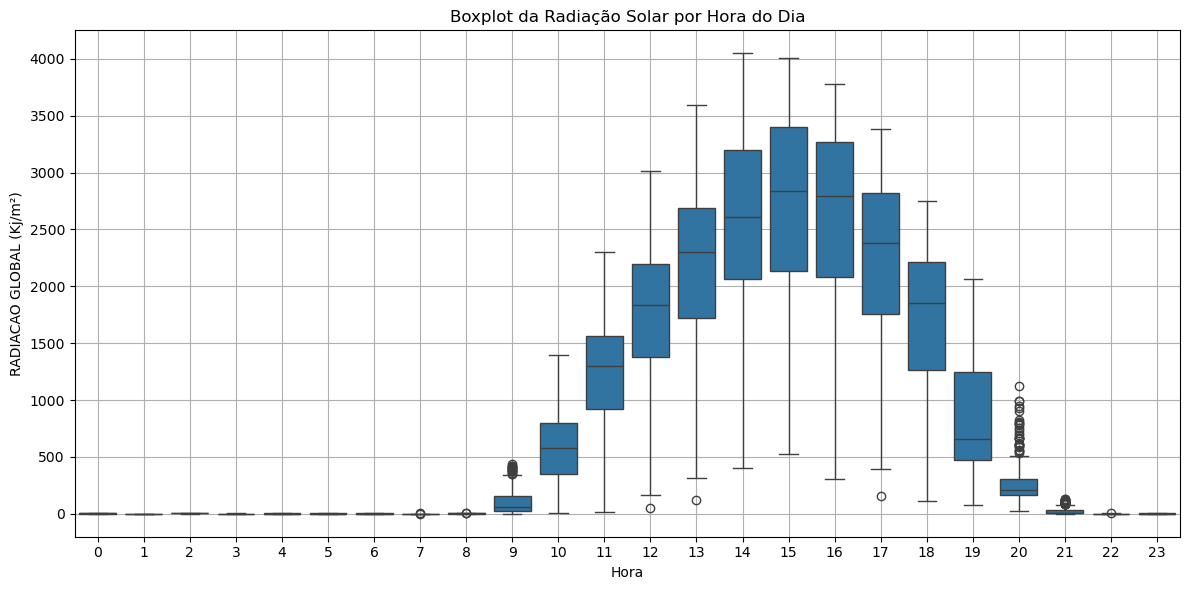

In [ ]:
# Colunas adicionais
df_radiacao['Dia'] = df_radiacao['Data'].dt.date
df_radiacao['Mês'] = df_radiacao['Data'].dt.month
df_radiacao['Semana'] = df_radiacao['Data'].dt.isocalendar().week

# Agrupamentos
media_hora = df_radiacao.groupby('Hora')['RADIACAO GLOBAL (Kj/m²)'].mean()
media_dia = df_radiacao.groupby('Dia')['RADIACAO GLOBAL (Kj/m²)'].mean()
media_mes = df_radiacao.groupby('Mês')['RADIACAO GLOBAL (Kj/m²)'].mean()

# Boxplot por hora
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_radiacao, x='Hora', y='RADIACAO GLOBAL (Kj/m²)')
plt.title('Boxplot da Radiação Solar por Hora do Dia')
plt.grid(True)
plt.tight_layout()
plt.show()



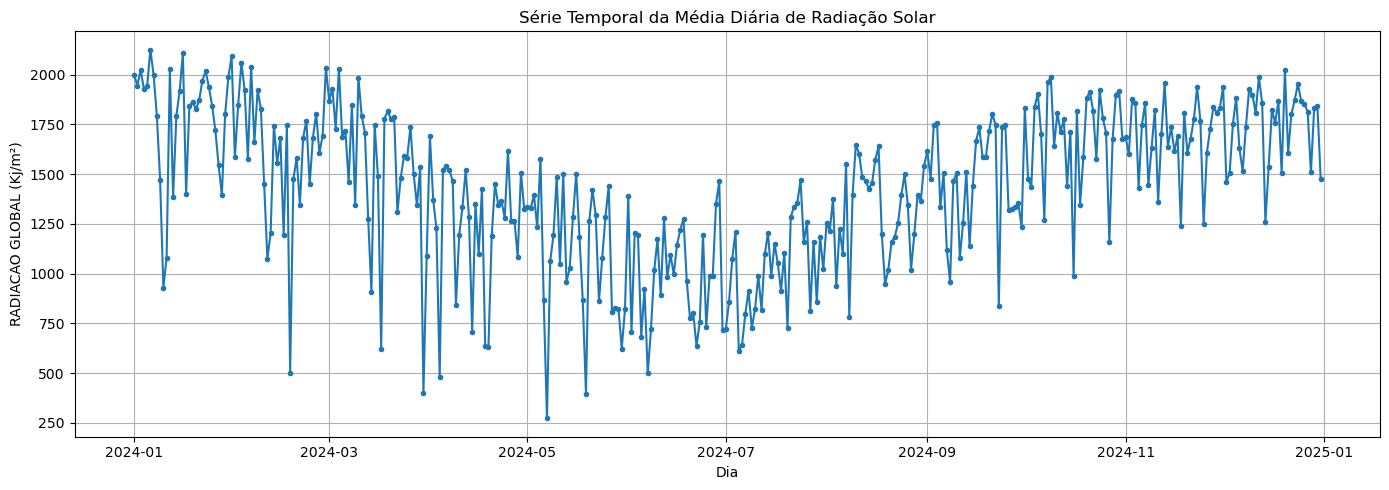

In [ ]:
# Série temporal diária
plt.figure(figsize=(14, 5))
media_dia.plot(marker='.')
plt.title('Série Temporal da Média Diária de Radiação Solar')
plt.xlabel('Dia')
plt.ylabel('RADIACAO GLOBAL (Kj/m²)')
plt.grid(True)
plt.tight_layout()
plt.show()


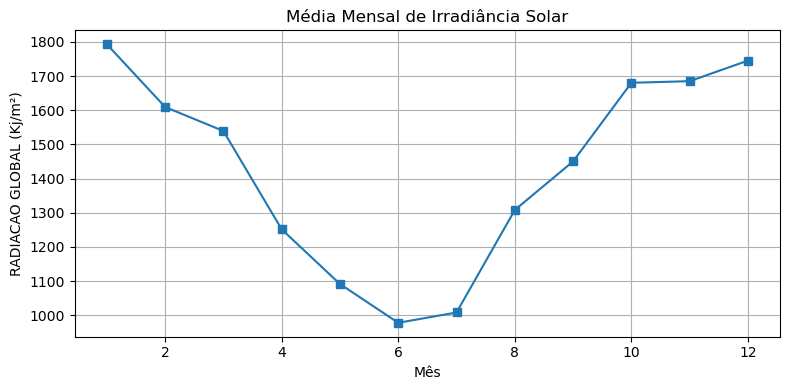

In [ ]:
# Curva de média mensal
plt.figure(figsize=(8, 4))
media_mes.plot(marker='s')
plt.title('Média Mensal de Irradiância Solar')
plt.xlabel('Mês')
plt.ylabel('RADIACAO GLOBAL (Kj/m²)')
plt.grid(True)
plt.tight_layout()
plt.show()

## Distribuição da Irradiância Solar em Horário Diurno

Para tornar a análise mais realista e focada na geração de energia solar, os dados foram filtrados para considerar apenas o período entre **06h e 18h**. Isso exclui horários noturnos e permite uma avaliação mais precisa do comportamento da radiação solar.

A seguir, aplicamos uma classificação refinada baseada em valores fixos:
- **Muito Baixa:** 0–100 Kj/m²
- **Baixa:** 101–500 Kj/m²
- **Média:** 501–1500 Kj/m²
- **Alta:** 1501–2500 Kj/m²
- **Muito Alta:** 2501+ Kj/m²

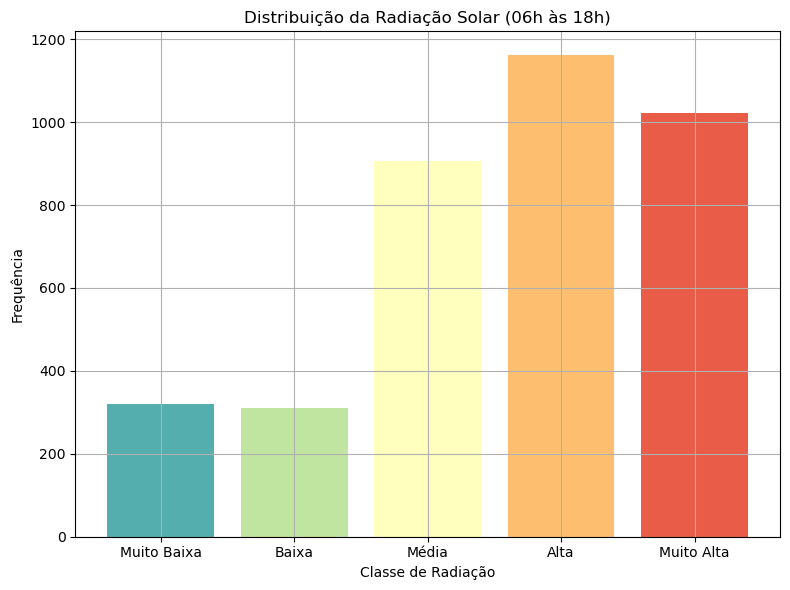

In [ ]:
# Converter data e hora
df_radiacao['Data'] = pd.to_datetime(df_radiacao['Data'], format='%d/%m/%y', errors='coerce')
df_radiacao['Hora'] = df_radiacao['Hora UTC'].str.extract(r'(\d{2})')[0].astype(float)

# Filtrar dados diurnos
df_dia = df_radiacao[(df_radiacao['Hora'] >= 6) & (df_radiacao['Hora'] <= 18)].copy()

# Converter valores e classificar
df_dia['RADIACAO GLOBAL (Kj/m²)'] = df_dia['RADIACAO GLOBAL (Kj/m²)'].astype(str).str.replace(',', '.')
df_dia['RADIACAO GLOBAL (Kj/m²)'] = pd.to_numeric(df_dia['RADIACAO GLOBAL (Kj/m²)'], errors='coerce')

bins = [0, 100, 500, 1500, 2500, float('inf')]
labels = ['Muito Baixa', 'Baixa', 'Média', 'Alta', 'Muito Alta']
df_dia['Classe_Radiacao'] = pd.cut(df_dia['RADIACAO GLOBAL (Kj/m²)'], bins=bins, labels=labels)

# Cores ordenadas: azul para baixa, vermelho para alta
ordem_cores = ['Muito Baixa', 'Baixa', 'Média', 'Alta', 'Muito Alta']
cores_personalizadas = sns.color_palette("Spectral", n_colors=5)[::-1]
classe_cor = dict(zip(ordem_cores, cores_personalizadas))

# Frequência por classe
frequencia_classe = df_dia['Classe_Radiacao'].value_counts().reindex(ordem_cores)

# Plot com cores ordenadas
plt.figure(figsize=(8, 6))
plt.bar(frequencia_classe.index, frequencia_classe.values,
        color=[classe_cor[cl] for cl in frequencia_classe.index])
plt.title('Distribuição da Radiação Solar (06h às 18h)')
plt.xlabel('Classe de Radiação')
plt.ylabel('Frequência')
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/37/0rq3kb_57y32ktqnrdcbdxg40000gn/T/ipykernel_19715/1113059667.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_dia.groupby(['Hora', 'Classe_Radiacao'])


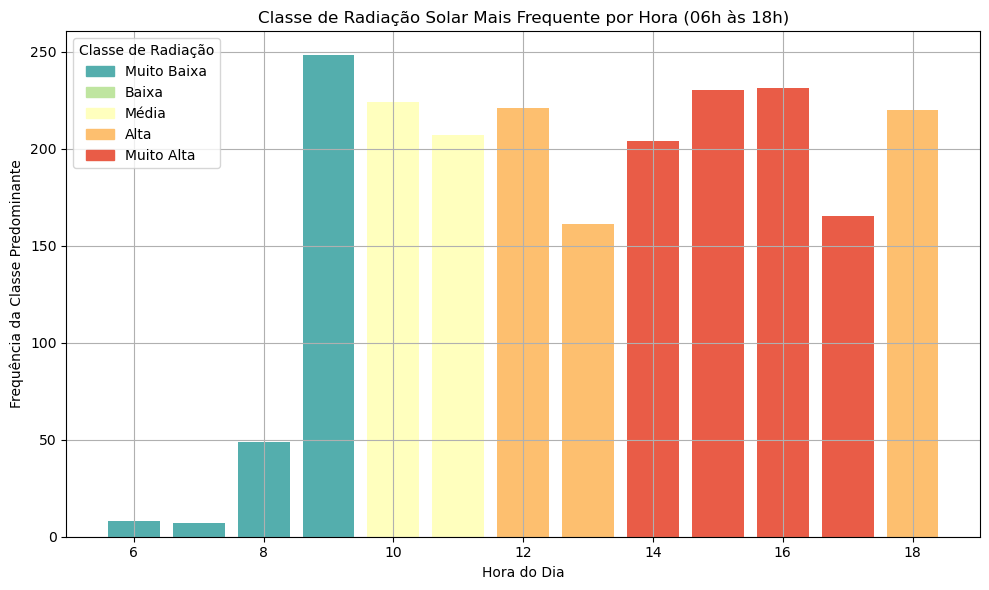

In [ ]:
# Pré-processamento e classificação
from matplotlib.patches import Patch

# Converter data e hora
df_radiacao['Data'] = pd.to_datetime(df_radiacao['Data'], format='%d/%m/%y', errors='coerce')
df_radiacao['Hora'] = df_radiacao['Hora UTC'].str.extract(r'(\d{2})')[0].astype(float)

# Filtrar dados diurnos
df_dia = df_radiacao[(df_radiacao['Hora'] >= 6) & (df_radiacao['Hora'] <= 18)].copy()

# Converter valores e classificar
df_dia['RADIACAO GLOBAL (Kj/m²)'] = df_dia['RADIACAO GLOBAL (Kj/m²)'].astype(str).str.replace(',', '.')
df_dia['RADIACAO GLOBAL (Kj/m²)'] = pd.to_numeric(df_dia['RADIACAO GLOBAL (Kj/m²)'], errors='coerce')

bins = [0, 100, 500, 1500, 2500, float('inf')]
labels = ['Muito Baixa', 'Baixa', 'Média', 'Alta', 'Muito Alta']
df_dia['Classe_Radiacao'] = pd.cut(df_dia['RADIACAO GLOBAL (Kj/m²)'], bins=bins, labels=labels)

# Cores ordenadas: azul para baixa, vermelho para alta
ordem_cores = ['Muito Baixa', 'Baixa', 'Média', 'Alta', 'Muito Alta']
cores_personalizadas = sns.color_palette("Spectral", n_colors=5)[::-1]
classe_cor = dict(zip(ordem_cores, cores_personalizadas))

# Agrupamento e transformação
classe_freq_counts = (
    df_dia.groupby(['Hora', 'Classe_Radiacao'])
    .size()
    .reset_index(name='Frequência')
    .pivot(index='Hora', columns='Classe_Radiacao', values='Frequência')
    .fillna(0)
)

# Identificar a classe predominante e sua frequência
classe_freq_max = classe_freq_counts.idxmax(axis=1)
classe_freq_height = classe_freq_counts.max(axis=1)

df_classe_predominante = pd.DataFrame({
    'Classe_Mais_Frequente': classe_freq_max.astype(str),
    'Frequência': classe_freq_height
})
df_classe_predominante['Cor'] = df_classe_predominante['Classe_Mais_Frequente'].map(classe_cor)

# Gráfico final
plt.figure(figsize=(10, 6))
plt.bar(df_classe_predominante.index, df_classe_predominante['Frequência'],
        color=df_classe_predominante['Cor'])

# Legenda
legenda = [Patch(color=classe_cor[cl], label=cl) for cl in ordem_cores]
plt.legend(handles=legenda, title='Classe de Radiação')

plt.title('Classe de Radiação Solar Mais Frequente por Hora (06h às 18h)')
plt.xlabel('Hora do Dia')
plt.ylabel('Frequência da Classe Predominante')
plt.grid(True)
plt.tight_layout()
plt.show()


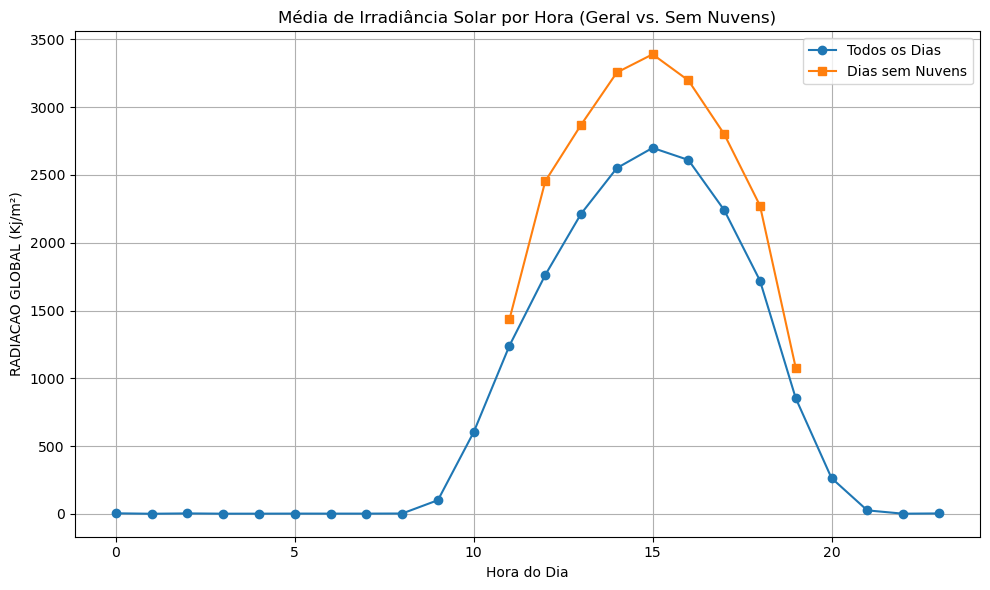

In [ ]:
# Comparação de Irradiância Solar por Hora: Todos os Dias vs. Dias Sem Nuvens
df_dia = df_dados.copy()

# Calcular média geral por hora
media_irradiancia_por_hora = df_dia.groupby('Hora')['RADIACAO GLOBAL (Kj/m²)'].mean()

# Preparar dados meteorológicos
df_dia['UMIDADE RELATIVA DO AR, HORARIA (%)'] = df_dia['UMIDADE RELATIVA DO AR, HORARIA (%)'].astype(str).str.replace(',', '.')
df_dia['UMIDADE RELATIVA DO AR, HORARIA (%)'] = pd.to_numeric(df_dia['UMIDADE RELATIVA DO AR, HORARIA (%)'], errors='coerce')

df_dia['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'] = df_dia['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'].astype(str).str.replace(',', '.')
df_dia['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'] = pd.to_numeric(df_dia['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'], errors='coerce')

# Filtrar dias com pouca nebulosidade
df_sem_nuvens = df_dia[(df_dia['UMIDADE RELATIVA DO AR, HORARIA (%)'] <= 60) & 
                       (df_dia['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'] == 0)]

# Calcular média para dias sem nuvens
media_sem_nuvens_por_hora = df_sem_nuvens.groupby('Hora')['RADIACAO GLOBAL (Kj/m²)'].mean()

# Visualização
plt.figure(figsize=(10, 6))
media_irradiancia_por_hora.plot(label='Todos os Dias', marker='o')
media_sem_nuvens_por_hora.plot(label='Dias sem Nuvens', marker='s')
plt.title('Média de Irradiância Solar por Hora (Geral vs. Sem Nuvens)')
plt.xlabel('Hora do Dia')
plt.ylabel('RADIACAO GLOBAL (Kj/m²)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Conclusão

Os resultados obtidos confirmam que o efeito das nuvens sobre a irradiância solar é complexo e influenciado por diversos fatores ambientais. Observamos que:

- **Altos níveis de umidade** e **ventos fortes** tendem a reduzir significativamente a irradiância;
- Mesmo sob cobertura parcial de nuvens, é possível ocorrer amplificação da radiação em certos horários;
- O modelo de regressão apresentou boa acurácia na previsão da irradiância com base em variáveis como temperatura, umidade e pressão.

Intuitivamente, esperamos que a irradiância solar atinja seu pico ao meio-dia, quando o sol está no ponto mais alto no céu. Porém, na prática, há alguns motivos para o pico ocorrer por volta das 13h ou 14h. 


Esse tipo de análise é fundamental para aplicações em **energia solar fotovoltaica**, **monitoramento ambiental** e **previsão meteorológica**, contribuindo para decisões mais precisas e sustentáveis.
